## task 1

### queries

1
```sql
SELECT title, premiered
FROM titles
WHERE premiered < 2018;

2
```sql
SELECT title, votes
FROM titles t
    JOIN rating r ON t.title_id = r.title_id
ORDER BY votes DESC
LIMIT 50;

3
```sql
SELECT title, rating, votes
FROM titles t
    JOIN rating r ON t.title_id = r.title_id
    JOIN film_genres fg ON r.title_id = fg.title_id
    JOIN genre_types gt ON fg.genre_id = gt.id
WHERE genre_name = 'Comedy' AND rating >= 7 AND premiered = 2019
ORDER BY votes DESC
LIMIT 10;

4
```sql
SELECT title, premiered
FROM titles
    JOIN crew c ON titles.title_id = c.title_id
    JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor'
    JOIN people p ON c.person_id = p.person_id AND p.name = 'Dennis Hopper';

5
```sql
SELECT premiered, COUNT(title) titles
FROM titles t
    JOIN film_genres fg ON t.title_id = fg.title_id
    JOIN genre_types gt ON gt.id = fg.genre_id AND gt.genre_name = 'Film-Noir'
GROUP BY premiered;

6
```sql
SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor' OR rc.role_type = 'actress'
    WHERE c.person_id = p.person_id
    )
ORDER BY age DESC
LIMIT 10;
```

```sql
SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor' OR rc.role_type = 'actress'
    WHERE c.person_id = p.person_id
    )
    AND age >= 100
ORDER BY died DESC;
```

### imports

In [16]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from numpy import ones
from matplotlib.ticker import PercentFormatter

con = sqlite3.connect('imdb_small_indexed.db')
cur = con.cursor()

### comedies vs detectives

In [5]:
genre_rating_query = '''
SELECT rating
FROM rating r
    JOIN film_genres fg on r.title_id = fg.title_id
    JOIN genre_types gt on fg.genre_id = gt.id
WHERE gt.genre_name = ?
ORDER BY rating DESC'''

comedies = pd.read_sql_query(genre_rating_query, con, params=['Comedy'])
detectives = pd.read_sql_query(genre_rating_query, con, params=['Crime'])

In [6]:
def rating_hist(data):
    plt.hist(data, range=(0, 10), weights=ones(len(data)) / len(data), alpha=0.5)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

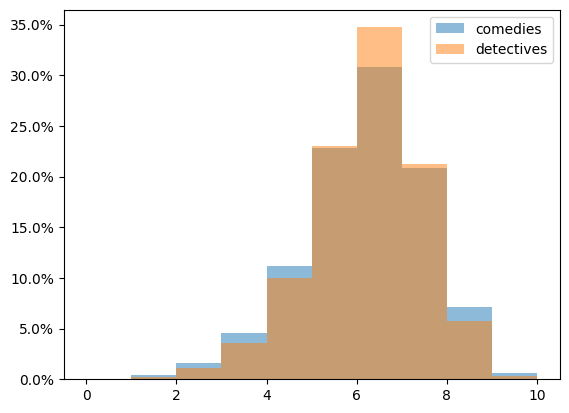

In [7]:
rating_hist(comedies)
rating_hist(detectives)
plt.legend(('comedies', 'detectives'))
plt.show()

### long-livers

In [30]:
create_top_longlivers_query = '''
CREATE TABLE top_longlivers
AS SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor'
    WHERE c.person_id = p.person_id
    ) AND age > 100
ORDER BY age DESC
LIMIT 10
'''

In [31]:
cur.execute(create_top_longlivers_query)

In [32]:
pd.read_sql_query('SELECT * FROM top_longlivers', con)

,name,born,died,age
0,Paul Walsh,21,None,2001
1,Koray Gelisen,1067,None,955
2,William S. Hooser,1836,None,186
3,California Truman,1849,None,173
4,Louis Hahn,1850,None,172
5,Charles Dungan,1853,None,169
6,Edmond Duquesne,1854,None,168
7,Jules Friquet,1855,None,167
8,Adolf Weisse,1855,None,167
9,William Parry,1856,None,166


In [33]:
create_over_100_query = '''
CREATE TABLE over_100
AS SELECT name, born, died, IFNULL(died, 2022) - born age
FROM people p
WHERE EXISTS(
    SELECT *
    FROM crew c
        JOIN role_categories rc ON rc.id = c.category AND rc.role_type = 'actor'
    WHERE c.person_id = p.person_id
    )
    AND age >= 100
ORDER BY died DESC;
'''

In [35]:
cur.execute(create_over_100_query)

In [36]:
pd.read_sql_query('SELECT * FROM over_100', con)

,name,born,died,age
0,Kirk Douglas,1916,2020.0,104
1,Earl Cameron,1917,2020.0,103
2,Armando Francioli,1919,2020.0,101
3,Gianrico Tedeschi,1920,2020.0,100
4,Konstantin Titov,1919,2020.0,101
...,...,...,...,...
1121,Emiko Sumiyoshi,1909,NaN,113
1122,Tazukô Otsuka,1912,NaN,110
1123,Olympio Guilherme,1902,NaN,120
1124,Oldrich Jezek,1909,NaN,113


## task 2

In [39]:
female_query = '''
SELECT premiered, genre_name, AVG(fem_perc) female_percentage
FROM (
    SELECT title, premiered, genre_name, SUM(CASE WHEN rc.role_type = 'actress' THEN 1.0 ELSE 0 END) / SUM(CASE WHEN rc.role_type = 'actress' or rc.role_type = 'actor' THEN 1 ELSE 0 END) fem_perc
    FROM titles t
        JOIN crew c ON t.title_id = c.title_id
        JOIN role_categories rc ON c.category = rc.id
        JOIN film_genres fg ON t.title_id = fg.title_id
        JOIN genre_types gt ON fg.genre_id = gt.id
    WHERE premiered is not null
    GROUP BY title
)
WHERE fem_perc is not null
GROUP BY premiered, genre_name
ORDER BY premiered DESC;
'''

In [40]:
fem_df = pd.read_sql_query(female_query, con)

In [41]:
fem_df

,premiered,genre_name,female_percentage
0,2028,Action,0.444444
1,2027,Adventure,0.000000
2,2027,Documentary,0.600000
3,2026,Action,0.750000
4,2026,Drama,0.000000
...,...,...,...
2650,1906,Musical,0.250000
2651,1903,Biography,0.363636
2652,1902,Drama,1.000000
2653,1900,Biography,0.166667


In [66]:
fem_df.pivot_table(values='female_percentage', index='premiered', columns='genre_name').sort_values(by='premiered', ascending=False)

genre_name,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
premiered,,,,,,,,,,,,,,,,,,,,,
2028,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024,0.412500,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,0.190476,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454545,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,NaN,NaN,NaN,NaN,0.500000,0.666667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,NaN,NaN,NaN,NaN,0.363636,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: xlabel='premiered'>

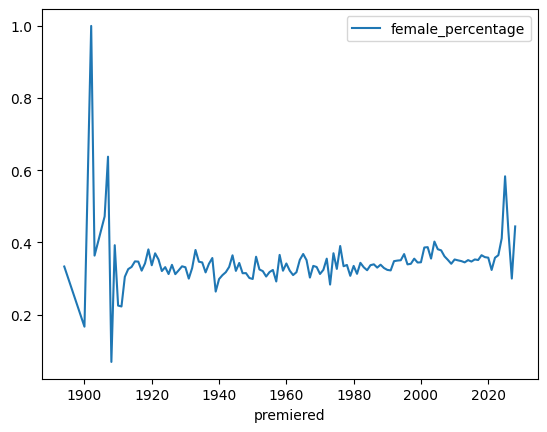

In [42]:
fem_df.pivot_table(values='female_percentage', index='premiered').sort_values(by='premiered', ascending=False).plot()

<function matplotlib.pyplot.show(close=None, block=None)>

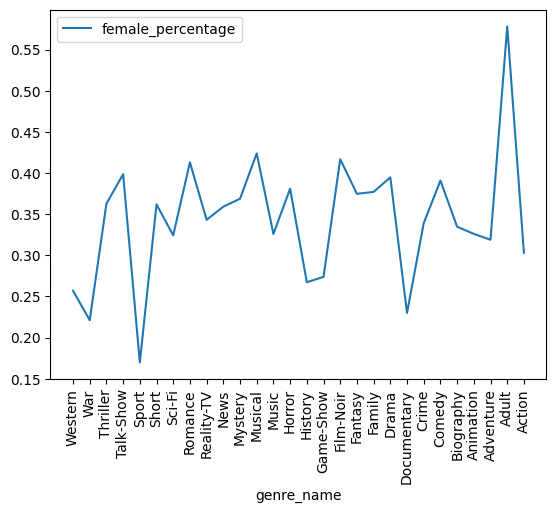

In [43]:
genre_pivot = fem_df.pivot_table(values='female_percentage', index='genre_name').sort_values(by='genre_name', ascending=False)
genre_pivot.plot()
plt.xticks(range(0, len(genre_pivot.index)), genre_pivot.index, rotation=90)
plt.show

<AxesSubplot: xlabel='premiered'>

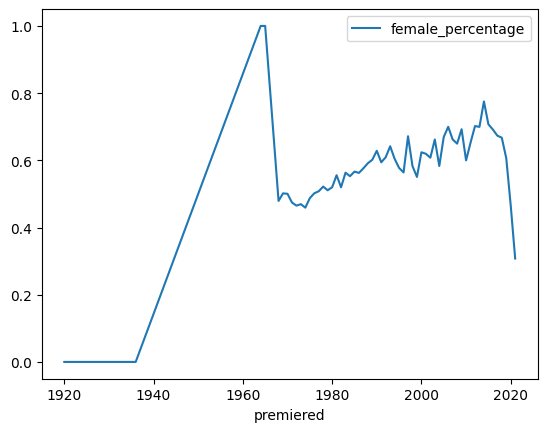

In [44]:
fem_df[fem_df['genre_name'] == 'Adult'].pivot_table(values='female_percentage', index='premiered').sort_values(by='premiered', ascending=False).plot()